# Retorno de uma Carteira com Python e Backtesting (BT)

## Biblioteca de Backtesting BT

Documentação: https://pmorissette.github.io/bt/

## Instalação e configurações Iniciais

In [3]:
import yfinance as yf
import bt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.arima import ndiffs

In [4]:
plt.style.use("seaborn-v0_8")
%matplotlib inline

## Funções

In [ ]:
def fixed_income_rates(bcb_code):
    rates = pd.read_json(f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{bcb_code}/dados?formato=json")

    rates['data'] = pd.to_datetime(rates['data'], dayfirst=True)
    rates.set_index('data', inplace=True)

    return rates

In [ ]:
def fixed_income_cumulative(bcb_code, start_date, end_date):
    security = fixed_income_rates(bcb_code)

    security_accumulated = (1 + security[start_date:end_date] / 100).cumprod()
    security_accumulated.iloc[0] = 1

    return security_accumulated

## Obtendo e tratando os dados

In [7]:
def sample_portfolio(tickers=None):
    if tickers is None:
        tickers = ['PETR4.SA', 'TOTS3.SA']
    start_date = '2020-01-01'
    end_date = '2022-12-31'
    cdi_code = 12

    variable_income = yf.download(tickers, start=start_date, end=end_date)['Adj Close']


    return variable_income.fillna(method='ffill')


portfolio = sample_portfolio()
print(portfolio.head(), end="\n\n")

print("Empty values:\n" + str(portfolio.isnull().any()))

[*********************100%***********************]  2 of 2 completed
             PETR4.SA   TOTS3.SA
Date                            
2020-01-02  12.977713  22.377893
2020-01-03  12.872027  22.853611
2020-01-06  13.024211  22.332590
2020-01-07  12.973485  22.426439
2020-01-08  12.893165  22.125479

Empty values:
PETR4.SA    False
TOTS3.SA    False
dtype: bool


<Axes: xlabel='Date'>

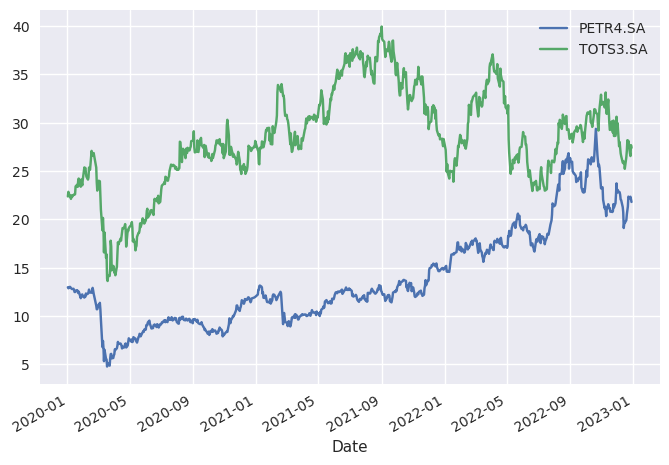

In [8]:
portfolio.plot()

## Backtesting

In [9]:
buy_hold = bt.Strategy('Buy & Hold',
                       [bt.algos.RunOnce(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighEqually(),
                        bt.algos.Rebalance()]
                       )

rebalance = bt.Strategy('Rebalance',
                        [bt.algos.RunMonthly(run_on_end_of_period=True),
                         bt.algos.SelectAll(),
                         bt.algos.WeighEqually(),
                         bt.algos.Rebalance()])

In [10]:
buy_hold_backtest = bt.Backtest(buy_hold, portfolio)
rebalance_backtest = bt.Backtest(rebalance, portfolio)

with np.errstate(divide='ignore'):
    buy_hold_out = bt.run(buy_hold_backtest)
    rebalance_out = bt.run(rebalance_backtest)

In [11]:
buy_hold_out.display_monthly_returns()

  Year    Jan    Feb     Mar    Apr    May     Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  -----  ------  -----  -----  -----  -----  -----  -----  -----
  2020   0.31  -7.67  -38.95  27.81   6.34   11.16   8.06   6.77  -7.66  -1.44  10.21  10.24   8.98
  2021  -3.11  -0.69   -2.22   5.32  11.91    9.34  -7.01  10.34  -5.62  -5.85   1.42  -1.56  10.37
  2022   7.29   9.38    4.43  -7.05  -0.66  -12.12  18.45  15.04  -5.22   5.49  -1.91  -9.13  20.76


In [12]:
rebalance_out.display_monthly_returns()

  Year    Jan    Feb     Mar    Apr    May     Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  -----  ------  -----  -----  -----  -----  -----  -----  -----
  2020   0.31  -7.9   -39.53  28.01   7.34   10.53   7.3    5.31  -8.26  -1.89  15.27  10.78  10.2
  2021  -3.47  -3.09    0.28   4.56  12.3     9.38  -7.32   9.66  -4.35  -4.77   2.57  -0.31  14.04
  2022   7.6    9.4     4.23  -6.54  -0.32  -12.55  17.82  14.08  -3.76   6.51  -2.36  -9.3   21.96


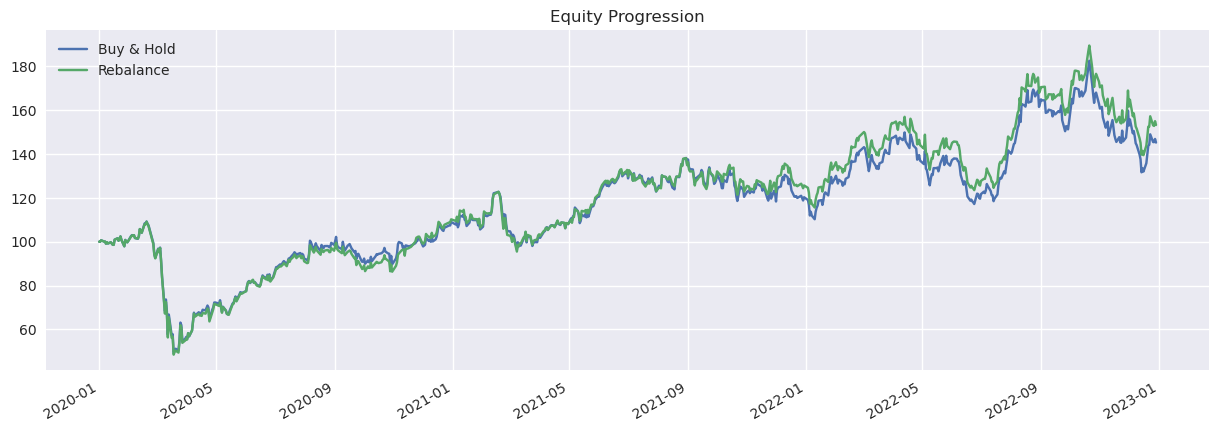

In [13]:
fig, ax = plt.subplots()

buy_hold_out.plot(ax=ax)
rebalance_out.plot(ax=ax)
plt.show()

### Rebalanceamento de Portfolio

In [ ]:
rebalance_out.get_transactions().tail()

### Pesos

In [ ]:
buy_hold_out.get_security_weights().tail()

In [ ]:
buy_hold_out.get_security_weights()

In [ ]:
buy_hold_out.plot_security_weights()
rebalance_out.plot_security_weights()

In [14]:
def get_weights(position):
    total_value = sum(position)
    return list(map(lambda security: security / total_value, position))

def get_positions(portfolio, weights, total):
    return total * portfolio.apply(
        lambda col: 1 / col * weights, axis=1)

def sample_position(portfolio, weights, total):
    starting_shares = total * (1 / portfolio.iloc[0] * weights)

    return portfolio.apply(
        lambda _: starting_shares, axis=1)

def operate_shares(position, shares, idx, inplace=False):
    if inplace:
        new_position = position
    else:
        new_position = position.copy()

    if (new_position.iloc[idx] + shares > 0).all():
        new_position.iloc[idx:] += shares
    else:
        raise ValueError("Can't have negative position")
    return new_position

def changes(portfolio):
    return pd.DataFrame(
        [
            1 - portfolio.iloc[i] / portfolio.iloc[i - 1] if i >= 1 else
            [0] * len(portfolio.columns)
            for i in range(len(portfolio))
        ],
        index=portfolio.index,
        columns=portfolio.columns
    )


def cumulative_changes(portfolio):
    portfolio_changes = changes(portfolio)

    return pd.DataFrame(
        [
            portfolio_changes.iloc[i] + portfolio_changes.iloc[i - 1] if i >= 1 else
            [0] * len(portfolio.columns)
            for i in range(len(portfolio))
        ],
        index=portfolio.index,
        columns=portfolio.columns
    )

In [177]:
portfolio = sample_portfolio()

[*********************100%***********************]  2 of 2 completed


In [15]:
position = sample_position(portfolio, weights=[1/2, 1/2], total=10e3)
position_value = portfolio * position

print("Position value over time: ")
print(position_value)
print("Final value: ", str(sum(position_value.iloc[-1])), end="\n\n")

# Compra de R$ 1000 em PETR4 7 dias atrás
dt7 = operate_shares(position, [1000 / portfolio.iloc[-7, 0], 0], -7, False)

# Compra de R$ 1000 em PETR4 2 dias atrás
dt2 = operate_shares(position, [1000 / portfolio.iloc[-2, 0], 0], -2, False)

# diff = sum(() * portfolio.iloc[-1])
print("Perda devido à dinheiro parado: R$", sum(portfolio.iloc[-1] * (dt2.iloc[-1] - dt7.iloc[-1])))

Position value over time: 
               PETR4.SA     TOTS3.SA
Date                                
2020-01-02  5000.000000  5000.000000
2020-01-03  4959.282026  5106.291851
2020-01-06  5017.914674  4989.877657
2020-01-07  4998.371193  5010.846829
2020-01-08  4967.425694  4943.601773
...                 ...          ...
2022-12-23  8613.724543  6286.215228
2022-12-26  8552.001827  5997.958144
2022-12-27  8610.295707  5933.654925
2022-12-28  8503.995189  6186.433946
2022-12-29  8401.124241  6124.348080

[745 rows x 2 columns]
Final value:  14525.472320775323

Perda devido à dinheiro parado: R$ -51.55374995522014


## Carteira com rebalanceamento em cima de predição de movimento

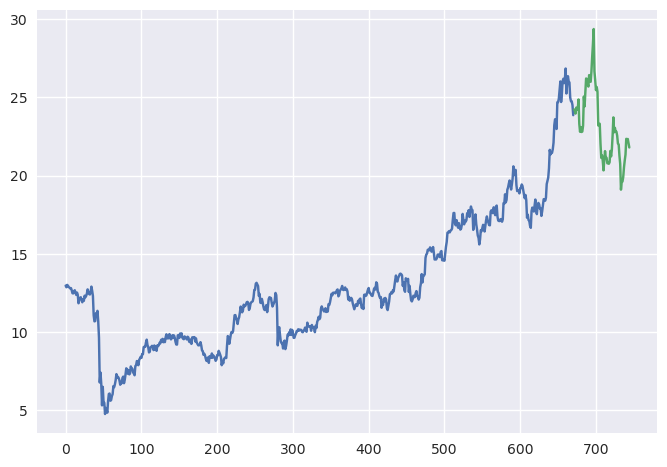

In [16]:
stock = list(portfolio["PETR4.SA"])

size = len(stock)
start = size - (size // 4)
split_size = 10

train_size, test_size = size - (size // split_size), size // split_size

train, test = stock[:train_size], stock[train_size:]

fig, ax = plt.subplots()
ax.plot(range(train_size), train)
ax.plot(range(train_size, train_size + test_size), test)

In [17]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

model = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6, maxiter=40,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=567.676, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=576.104, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=577.712, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=577.690, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=575.390, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=577.731, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=580.443, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=579.448, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=569.807, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=579.608, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=573.894, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=575.493, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=570.409, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=566.018, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=576.4

In [18]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

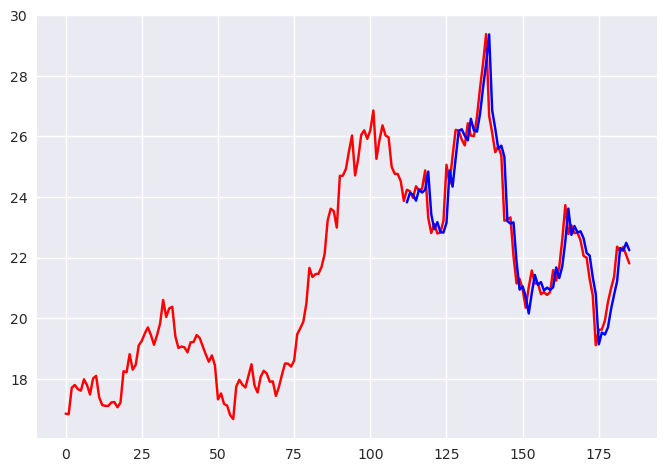

In [19]:
plt.plot(range(len(stock) - start), stock[start:], c='red')
plt.plot(range(train_size - start, train_size + test_size - start), forecasts, c="blue")
plt.show()